# Prédiction de la consommation électrique
<ul>
    <li>Données de ville de Tétouan au Maroc</li> 
    <ul>
        <li>Puissance de consommation en KW</li>
        <li>3 zones</li>
    </ul>
    <li>Série temporelle multivariée</li>  
     <ul>
        <li>Température, Humidité, vitesse du vent, …</li>
    </ul>
    <li>Données enregistrées sur l’année 2017</li>  

</ul>


In [1]:
import os
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import eli5
import xgboost as xgb
from datetime import datetime 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from eli5.sklearn import PermutationImportance

#from keras.layers import Dense

In [2]:
from src import data_analysis, data_featuring, data_gathering, model, prediction

### Files paths

In [3]:
#File energy path
file_energy = "Datasets/Tetuan_City_power_consumption.csv"

### Loading data

In [4]:
# df_energy = pd.read_csv(file_energy)
df_energy = data_gathering.load_dataset(data_filename=file_energy, col_sep=",", b_rename_cols=True)

# Ajouter des informations plus précises sur les dates d'enregistrement
# pour des analyses plus fines sur les enregistrements
df_energy = data_featuring.create_datetime_features(df_data=df_energy)

# Ajouter les moyennes des consommations précédentes
df_energy = data_featuring.add_consumption_average(df_energy, rolling_hours=1)
df_energy = data_featuring.add_consumption_average(df_energy, rolling_hours=2)
df_energy = data_featuring.add_consumption_average(df_energy, rolling_hours=3)
df_energy = data_featuring.add_consumption_average(df_energy, rolling_hours=4)
df_energy = data_featuring.add_consumption_average(df_energy, rolling_hours=5)

### Understanding Features 

In [5]:
#let's display the 5 first and last lines of our dataset
display(df_energy)

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,Hour,DayOfWeek,...,Z3_Mean_Consumption_2H,Z1_Mean_Consumption_3H,Z2_Mean_Consumption_3H,Z3_Mean_Consumption_3H,Z1_Mean_Consumption_4H,Z2_Mean_Consumption_4H,Z3_Mean_Consumption_4H,Z1_Mean_Consumption_5H,Z2_Mean_Consumption_5H,Z3_Mean_Consumption_5H
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,0,6,...,20240.963860,34055.696200,16128.875380,20240.963860,34055.696200,16128.875380,20240.963860,34055.696200,16128.875380,20240.963860
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,0,6,...,20186.024100,31935.189870,17751.975685,20186.024100,31935.189870,17751.975685,20186.024100,31935.189870,17751.975685,20186.024100
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,0,6,...,20013.493977,30999.493670,18170.212767,20013.493977,30999.493670,18170.212767,20013.493977,30999.493670,18170.212767,20013.493977
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,0,6,...,19734.939760,30306.835442,18217.933130,19734.939760,30306.835442,18217.933130,19734.939760,30306.835442,18217.933130,19734.939760
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,0,6,...,19476.433736,29712.607594,18148.814590,19476.433736,29712.607594,18148.814590,19476.433736,29712.607594,18148.814590,19476.433736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,23,5,...,15783.913565,34841.064638,29838.191674,16168.067227,35465.652725,30467.167843,16375.270108,35936.121673,30908.499540,16464.441777
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,23,5,...,15595.198078,34466.582171,29511.915721,16018.887554,35163.498098,30198.373734,16270.588235,35683.041825,30687.327401,16390.108043
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,23,5,...,15363.265305,34052.893958,29143.295489,15845.378151,34831.939163,29898.128260,16137.334934,35402.382763,30438.662166,16293.109243


In [6]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52416 entries, 2017-01-01 00:00:00 to 2017-12-30 23:50:00
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Temperature               52416 non-null  float64
 1   Humidity                  52416 non-null  float64
 2   Wind Speed                52416 non-null  float64
 3   general diffuse flows     52416 non-null  float64
 4   diffuse flows             52416 non-null  float64
 5   Zone 1 Power Consumption  52416 non-null  float64
 6   Zone 2 Power Consumption  52416 non-null  float64
 7   Zone 3 Power Consumption  52416 non-null  float64
 8   Hour                      52416 non-null  int64  
 9   DayOfWeek                 52416 non-null  int64  
 10  Month                     52416 non-null  int64  
 11  Year                      52416 non-null  int64  
 12  DayOfYear                 52416 non-null  int64  
 13  WeekOfYear                

A la lecture on remarque qu'il n'y a pas de valeurs manquantes dans notre dataset. Seulement que la variable DateTime n'est pas un datetime

In [7]:
# Format WeekOfYear columns
df_energy['WeekOfYear'] = df_energy['WeekOfYear'].astype('int')
df_energy

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,Hour,DayOfWeek,...,Z3_Mean_Consumption_2H,Z1_Mean_Consumption_3H,Z2_Mean_Consumption_3H,Z3_Mean_Consumption_3H,Z1_Mean_Consumption_4H,Z2_Mean_Consumption_4H,Z3_Mean_Consumption_4H,Z1_Mean_Consumption_5H,Z2_Mean_Consumption_5H,Z3_Mean_Consumption_5H
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,0,6,...,20240.963860,34055.696200,16128.875380,20240.963860,34055.696200,16128.875380,20240.963860,34055.696200,16128.875380,20240.963860
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,0,6,...,20186.024100,31935.189870,17751.975685,20186.024100,31935.189870,17751.975685,20186.024100,31935.189870,17751.975685,20186.024100
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,0,6,...,20013.493977,30999.493670,18170.212767,20013.493977,30999.493670,18170.212767,20013.493977,30999.493670,18170.212767,20013.493977
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,0,6,...,19734.939760,30306.835442,18217.933130,19734.939760,30306.835442,18217.933130,19734.939760,30306.835442,18217.933130,19734.939760
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,0,6,...,19476.433736,29712.607594,18148.814590,19476.433736,29712.607594,18148.814590,19476.433736,29712.607594,18148.814590,19476.433736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,23,5,...,15783.913565,34841.064638,29838.191674,16168.067227,35465.652725,30467.167843,16375.270108,35936.121673,30908.499540,16464.441777
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,23,5,...,15595.198078,34466.582171,29511.915721,16018.887554,35163.498098,30198.373734,16270.588235,35683.041825,30687.327401,16390.108043
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,23,5,...,15363.265305,34052.893958,29143.295489,15845.378151,34831.939163,29898.128260,16137.334934,35402.382763,30438.662166,16293.109243


### Statistical analysis

In [8]:
#Let's diplay a basic statical 
df_energy.describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,Hour,DayOfWeek,...,Z3_Mean_Consumption_2H,Z1_Mean_Consumption_3H,Z2_Mean_Consumption_3H,Z3_Mean_Consumption_3H,Z1_Mean_Consumption_4H,Z2_Mean_Consumption_4H,Z3_Mean_Consumption_4H,Z1_Mean_Consumption_5H,Z2_Mean_Consumption_5H,Z3_Mean_Consumption_5H
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,...,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,18.810024,68.259518,1.959489,182.696614,75.028022,32344.970564,21042.509082,17835.406218,11.500000,3.000000,...,17835.962794,32344.628369,21040.978635,17836.128455,32344.149514,21040.219442,17836.226019,32343.564693,21039.379534,17836.278325
std,5.815476,15.551177,2.348862,264.400960,124.210949,7130.562564,5201.465892,6622.165099,6.922253,2.000019,...,6519.118500,6740.114392,4977.179313,6426.523350,6514.595044,4848.111985,6321.061907,6266.342719,4704.805813,6208.728517
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070,0.000000,0.000000,...,6420.168067,15590.886076,9528.105906,6803.041216,15761.772152,9936.507129,7158.223289,15826.430380,10109.450102,7484.081633
25%,14.410000,58.310000,0.078000,0.062000,0.122000,26310.668692,16980.766032,13129.326630,5.750000,1.000000,...,13138.349348,26591.797298,17183.896771,13178.012125,26824.770655,17295.109871,13253.686560,27073.225532,17442.514321,13357.748744
50%,18.780000,69.860000,0.086000,5.035500,4.456000,32265.920340,20823.168405,16415.117470,11.500000,3.000000,...,16449.603523,32506.505961,20866.023271,16495.349040,32597.920354,20860.142864,16545.995919,32650.311165,20851.993847,16587.428683
75%,22.890000,81.400000,4.915000,319.600000,101.000000,37309.018185,24713.717520,21624.100420,17.250000,5.000000,...,21576.166730,37253.691859,24533.943089,21514.421456,37179.989276,24418.668870,21455.178754,37108.314046,24299.679477,21426.512287
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120,37408.860760,47598.326360,23.000000,6.000000,...,46737.740586,50524.839067,35258.078142,45857.071129,49333.185349,34502.217530,44647.280335,47991.947020,34225.822785,43195.983264


La température dans la ville de Tetuan varie entre 3°C et 40°C avec une moyenne annuelle de 18,81°C.
L'humidité dans la ville de Tetuan varie entre 11% et 94% avec une moyenne annuelle de 68,25%.
A certaine période, très peu de vents et à d'autres périodes des vents violents soufflant à plus de 1163 km/h.
La consommation en énergie électrique de la zone 1 peut atteint son pic à 52204,3951 KW et son plus bas niveau à 13895,6962 KW 
La consommation en énergie électrique de la zone 2 peut atteint son pic à 37408.86076 KW et son plus bas niveau à 8560,081466KW.
La consommation en énergie électrique de la zone 3 peut atteint son pic à 47598.32636 KW et son plus bas niveau à 5935,17407KW.
La consommation moyenne d'électricité est identique dans ces trois zones.

###  Visualisation

Text(0, 0.5, 'Vitesse du vent (Km/h)')

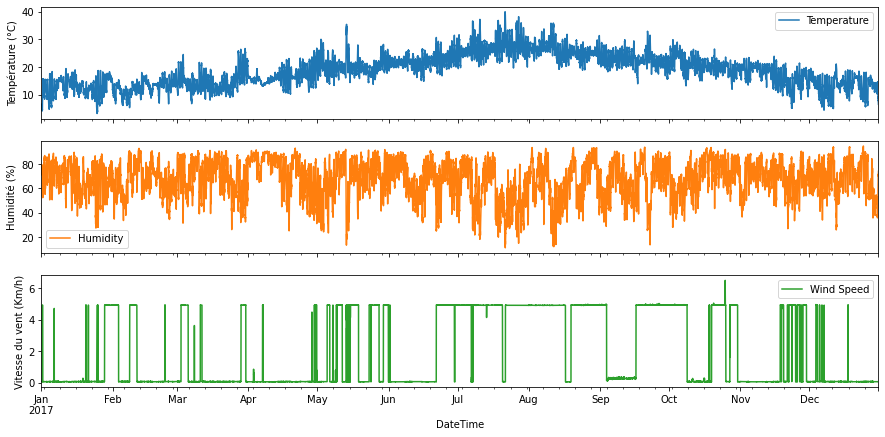

In [9]:
#visualisation de la température, de l'humidité et la vitesse du vent

mask_feature = ['Temperature', 'Humidity', 'Wind Speed']

ax_multiplot = df_energy[mask_feature].plot(subplots=True, figsize=(15, 7))
ax_multiplot[0].set_ylabel("Température (°C)")
ax_multiplot[1].set_ylabel("Humidité (%)")
ax_multiplot[2].set_ylabel("Vitesse du vent (Km/h)")


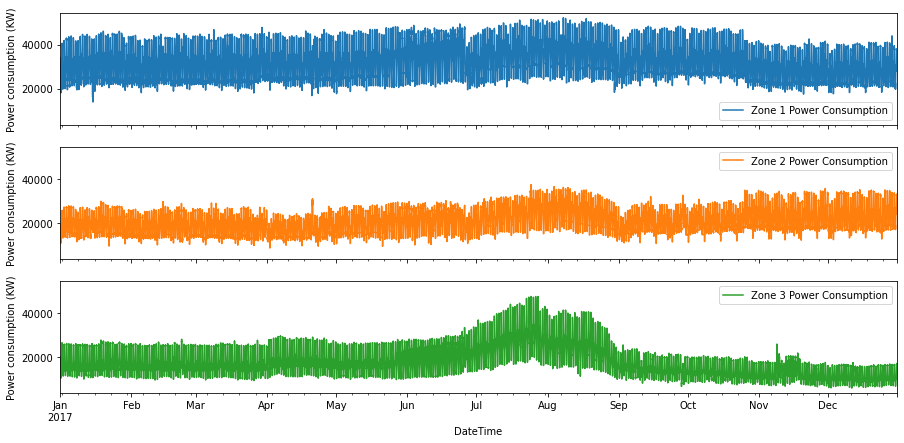

In [10]:
#visualisation de la consommation d'énergie sur l'année 2017 par zones 
data_analysis.display_consumption_daily(df_data=df_energy, figsize=(20, 15), day_num='all')

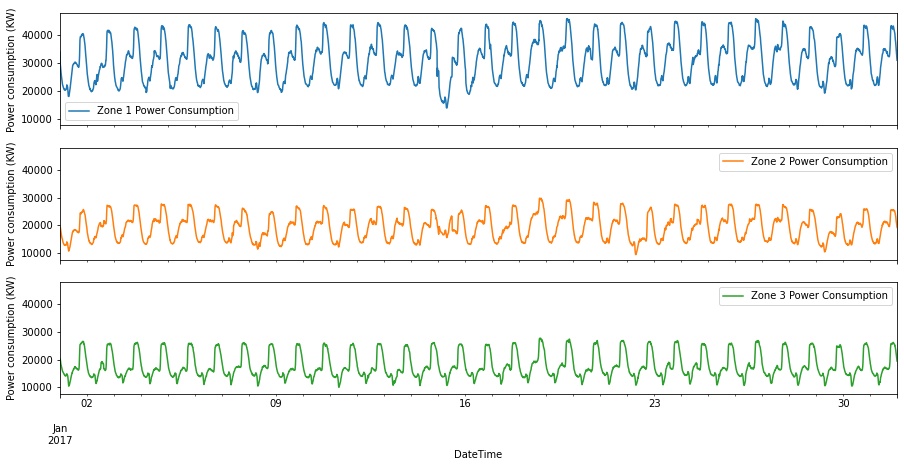

In [11]:
# visualisation de la consommation d'énergie mensuelle sur l'année 2017 par zones
data_analysis.display_consumption_monthly(df_data=df_energy, figsize=(20, 15), month_num=1) #Janvier 2017

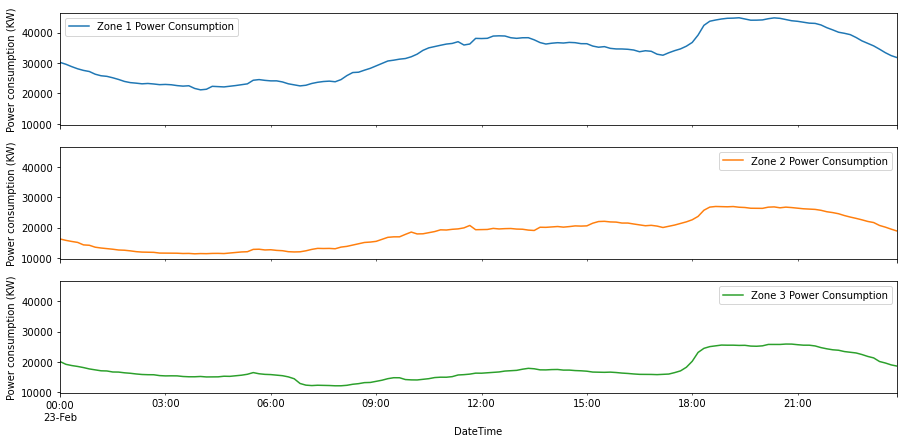

In [12]:
#consommation énergétique intrajournalière 
data_analysis.display_consumption_daily(df_data=df_energy, figsize=(20, 15), day_num=54) #23 Février

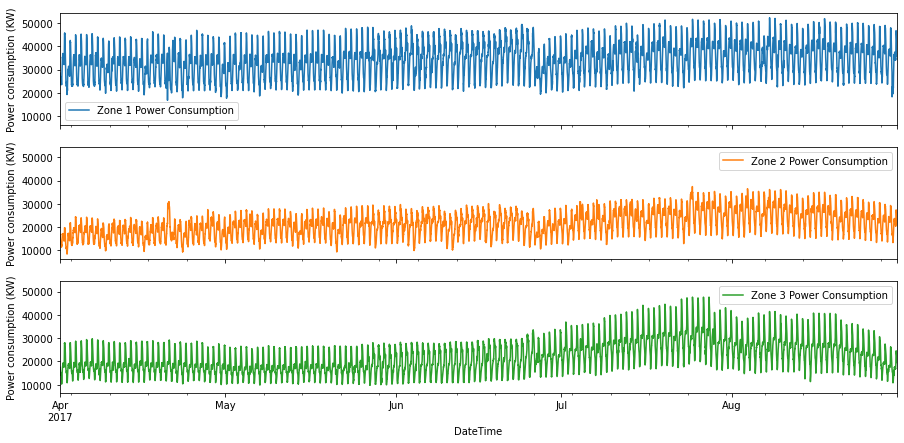

In [13]:
#consommation énergétique sur une période
data_analysis.display_consumption_period(df_data=df_energy, figsize=(20, 15), start_date="2017-04-01" , end_date="2017-08-30")

<AxesSubplot:>

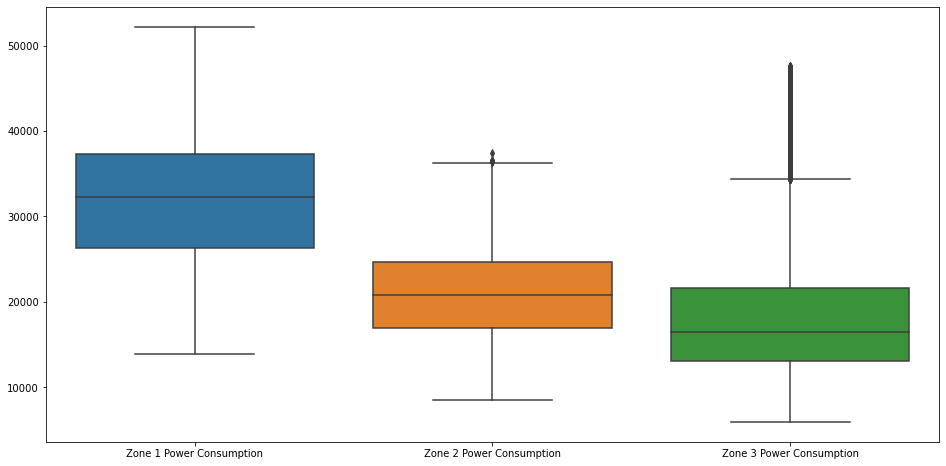

In [14]:
# boxplot de la consommation énergétique par zone
plt.figure(figsize=(16,8))
data_feature=df_energy[["Zone 1 Power Consumption","Zone 2 Power Consumption","Zone 3 Power Consumption"]]
sns.boxplot(data=data_feature)

La zone 1 est la pls grande consommatrice d'électicité suivi de la zone 2 et enfin la zone 3.

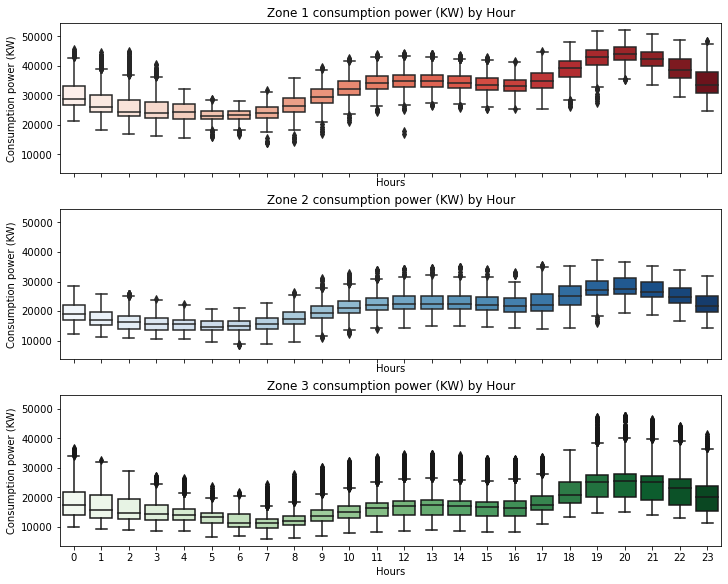

In [15]:
data_analysis.display_consumption_resume(df_energy, scale="Hours", figsize=(10, 8))

En fin de journée entre 18h et 23h on note une hausse de consommation électrique dans les différentes dû à l'activité social nocturne des ménages. Par contre en début de journée, entre 3h et 9h on note une baisse de la consommation électrique dans toutes les zones.

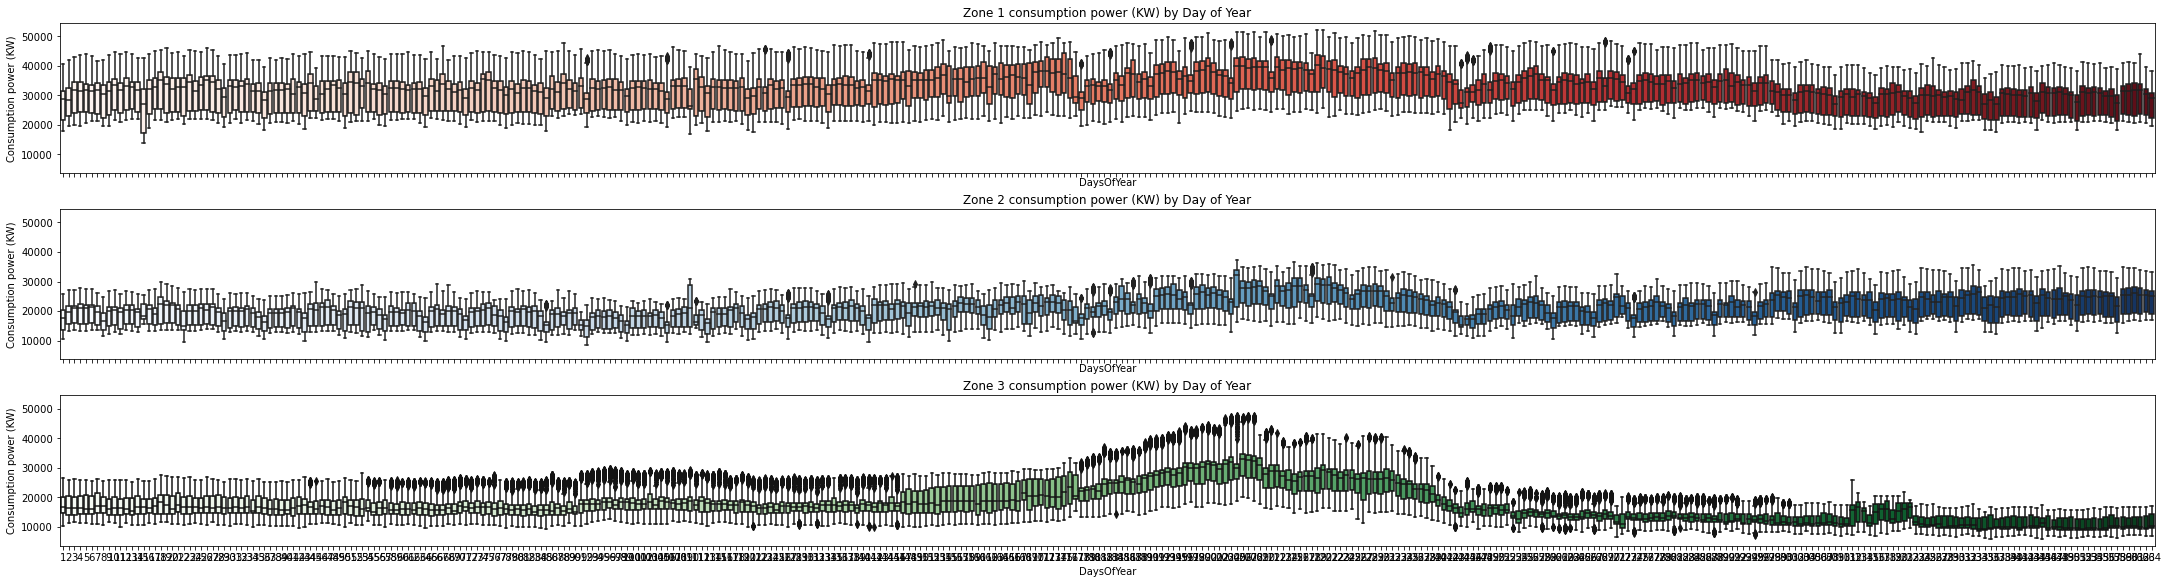

In [16]:
data_analysis.display_consumption_resume(df_energy, scale="days", figsize=(30, 8))

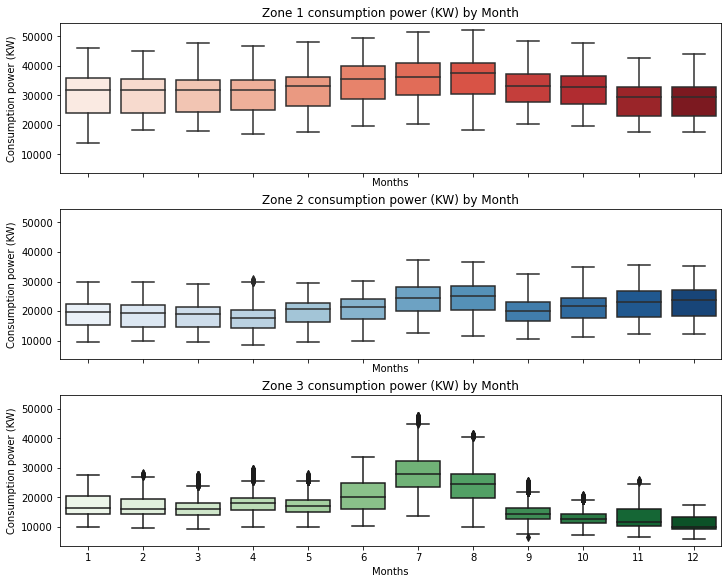

In [17]:
data_analysis.display_consumption_resume(df_energy, scale="Months", figsize=(10, 8))

En période de vacances (Juin à Août) on remarque une consommation électrique élevée. C'est dû aux activités de loisir des enfants et des jeunes.

Text(0.5, 1.0, "Histogramme de la consommation d'énergie zone 3")

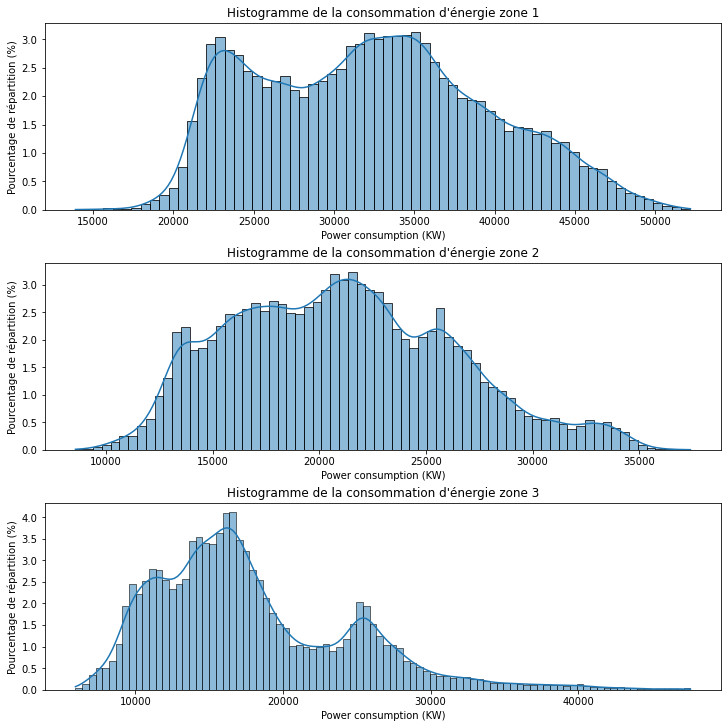

In [18]:
fig, axis = plt.subplots(3,1, figsize=(10,10), constrained_layout=True)
sns.histplot(data=df_energy, x="Zone 1 Power Consumption", stat="percent", kde=True, ax=axis[0])
sns.histplot(data=df_energy, x="Zone 2 Power Consumption", stat="percent", kde=True, ax=axis[1])
sns.histplot(data=df_energy, x="Zone 3 Power Consumption", stat="percent", kde=True, ax=axis[2])

axis[0].set_xlabel('Power consumption (KW)')
axis[0].set_ylabel('Pourcentage de répartition (%)')
axis[0].set_title("Histogramme de la consommation d'énergie zone 1")

axis[1].set_xlabel('Power consumption (KW)')
axis[1].set_ylabel('Pourcentage de répartition (%)')
axis[1].set_title("Histogramme de la consommation d'énergie zone 2")

axis[2].set_xlabel('Power consumption (KW)')
axis[2].set_ylabel('Pourcentage de répartition (%)')
axis[2].set_title("Histogramme de la consommation d'énergie zone 3")


L'histogramme nous renseigne sur la distribution des variables de consommation électrique qui n'est pas normale.

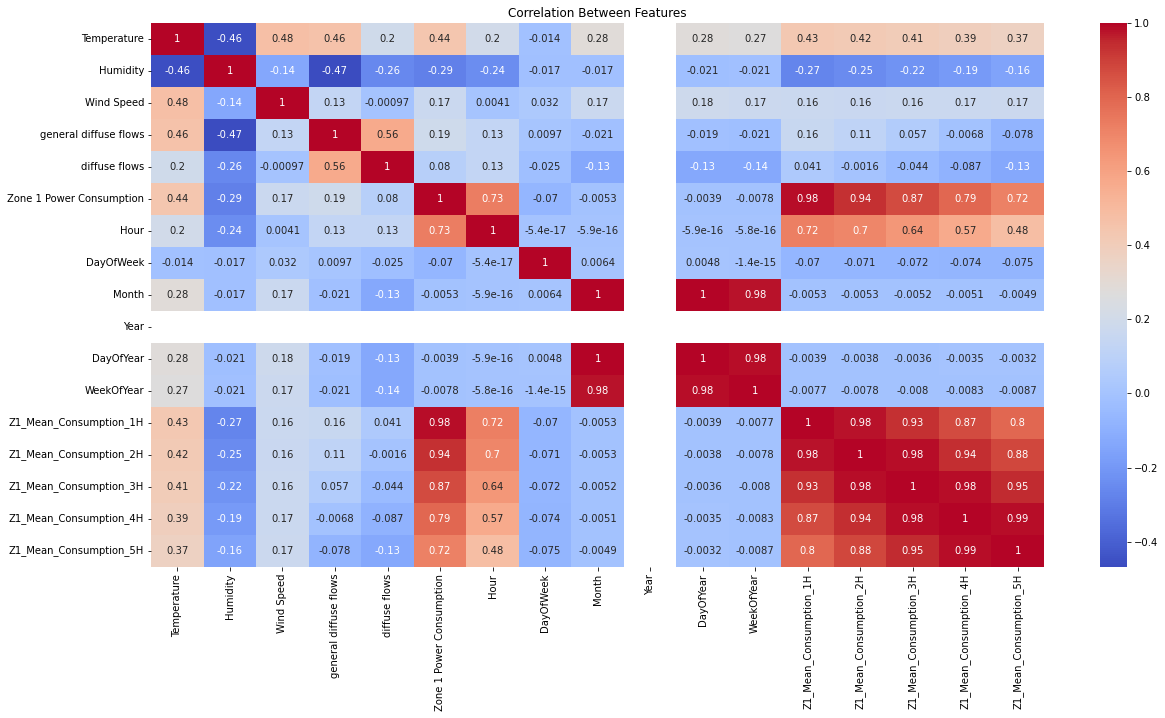

In [19]:
plt.figure(figsize=(20, 10))
# Heatmap of correlation between features
mask = ['Temperature', 'Humidity', 'Wind Speed' , 'general diffuse flows', 'diffuse flows', 
'Zone 1 Power Consumption', 'Hour', 'DayOfWeek', 'Month', 'Year', 'DayOfYear', 'WeekOfYear', 
'Z1_Mean_Consumption_1H', 'Z1_Mean_Consumption_2H', 'Z1_Mean_Consumption_3H', 'Z1_Mean_Consumption_4H',
'Z1_Mean_Consumption_5H']               
corr = df_energy[mask].corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Correlation Between Features')
plt.show()

On remarque que la consommation électrique de la zone 1 et la consommation électrique de la zone 2 sont corrélés positivement à la variable Hour(Heure). Il s'agit d'une corrélation modérément forte.
la consommation électrique de la zone 3 est faiblement corrélé à la variable Hour(Heure)


### Decomposition en saisonnalité et tendance

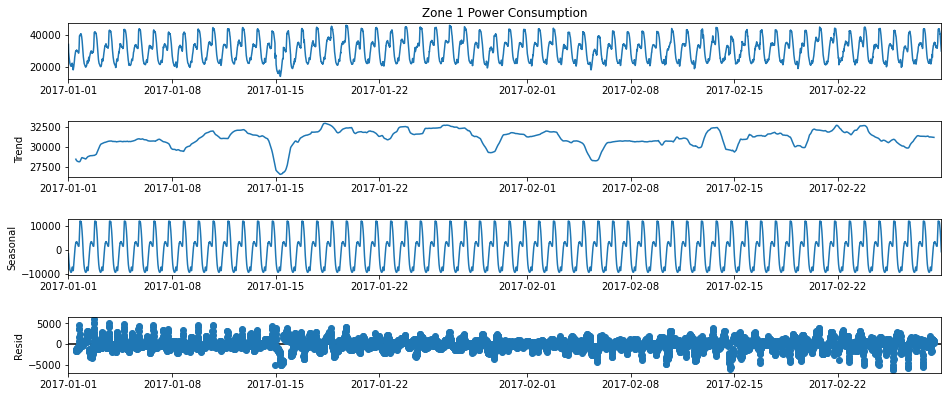

In [20]:
decomposition = seasonal_decompose(df_energy.loc["2017-01":"2017-02", "Zone 1 Power Consumption"], period=6*24)

fig=decomposition.plot()
fig.set_size_inches((15, 6))

### Stationnarité

In [21]:
# adfuller(df_energy["Zone 1 Power Consumption"])
mask = ["Zone 1 Power Consumption","Zone 2 Power Consumption","Zone 3 Power Consumption"]
for target in df_energy[mask]:
    result = adfuller(df_energy[target])
    print(f"{target} :")
    print(f"Statistique ADF :, {result[0]}\np-value :, {result[1]}\n")
#     print(f"p-value :, {result[1]}\n")

Zone 1 Power Consumption :
Statistique ADF :, -32.12127853462605
p-value :, 0.0

Zone 2 Power Consumption :
Statistique ADF :, -25.222163771003686
p-value :, 0.0

Zone 3 Power Consumption :
Statistique ADF :, -16.366867975156726
p-value :, 2.835133086904371e-29



Les séries de consommation électrique des zones sont stationnaire

### Autocorrélation

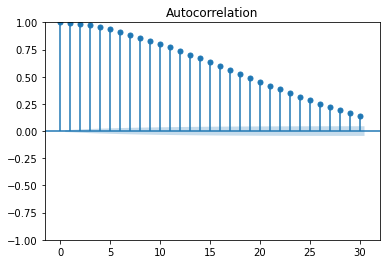

Autocorrelation de la serie Zone 1 Power Consumption


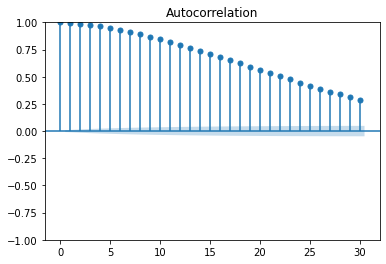

Autocorrelation de la serie Zone 2 Power Consumption


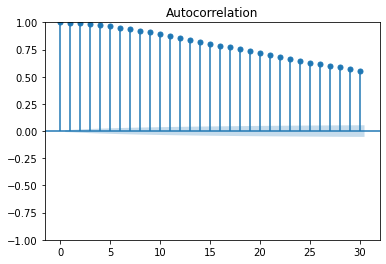

Autocorrelation de la serie Zone 3 Power Consumption


In [22]:
from statsmodels.graphics import tsaplots

#plot autocorrelation function
fig = tsaplots.plot_acf(df_energy["Zone 1 Power Consumption"], lags=30)
plt.show()
print("Autocorrelation de la serie Zone 1 Power Consumption")

fig = tsaplots.plot_acf(df_energy["Zone 2 Power Consumption"], lags=30)
plt.show()
print("Autocorrelation de la serie Zone 2 Power Consumption")

fig = tsaplots.plot_acf(df_energy["Zone 3 Power Consumption"], lags=30)
plt.show()
print("Autocorrelation de la serie Zone 3 Power Consumption")

On remarque une décroissance progressive de l'autocorrélation. On soupconne que les séries sont autocoréllées jusqu'a l'ordre 6.

### Construction des bases de tests et d'apprentissage

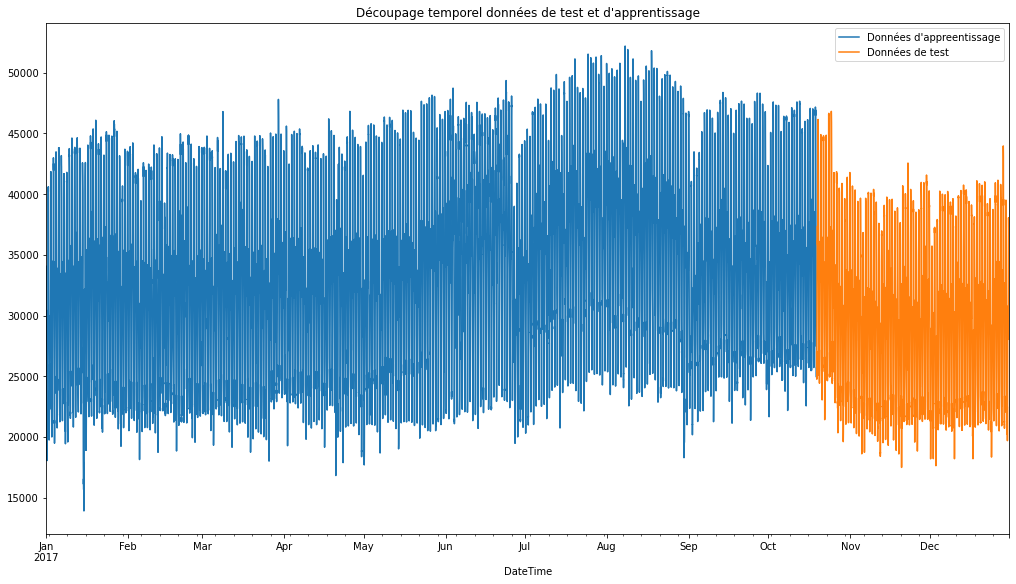

In [23]:
zone_str = "Z1"
target_cols = ["Zone 1 Power Consumption"]
d_train_test, scaler = model.build_train_test_datasets(df_data=df_energy,
                              input_cols=['Temperature', 'Humidity',
                                          'Wind Speed', 'DayOfYear', 'Hour',
                                          'DayOfWeek', 'Month',
                                          '{}_Mean_Consumption_1H'.format(zone_str),
                                          '{}_Mean_Consumption_2H'.format(zone_str),
                                          '{}_Mean_Consumption_3H'.format(zone_str),
                                          '{}_Mean_Consumption_4H'.format(zone_str),
                                          '{}_Mean_Consumption_5H'.format(zone_str)], 
                              target_cols=target_cols,
                              train_ratio=0.8, scaler_str=None)

X_train = d_train_test["NonScaled"]["train"]["Inputs"]
y_train = d_train_test["NonScaled"]["train"]["Target"]
X_test = d_train_test["NonScaled"]["test"]["Inputs"]
y_test = d_train_test["NonScaled"]["test"]["Target"]

In [24]:
# # scission de la base de données en base d'apprentissage, test

# df_data = model.split(database=df_energy, alpha=.8)
# database_train = df_data[0]
# database_test = df_data[1]

In [25]:
# #Selection des trois target
# target1 = database_train["Zone 1 Power Consumption"]
# target2 = database_train["Zone 2 Power Consumption"]
# target3 = database_train["Zone 3 Power Consumption"]

# target1_test = database_test["Zone 1 Power Consumption"]
# target2_test = database_test["Zone 2 Power Consumption"]
# target3_test = database_test["Zone 3 Power Consumption"]

# # selection des features
# mask1=['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows', 
#       'Hour', 'DayOfWeek', 'Month', 'DayOfYear', 'WeekOfYear', 'Z1_Mean_Consumption_1H',
#      'Z1_Mean_Consumption_2H', 'Z1_Mean_Consumption_3H', 'Z1_Mean_Consumption_4H', 'Z1_Mean_Consumption_5H']

# mask2=['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows', 
#       'Hour', 'DayOfWeek', 'Month', 'DayOfYear', 'WeekOfYear', 'Z2_Mean_Consumption_1H',
#      'Z2_Mean_Consumption_2H', 'Z2_Mean_Consumption_3H', 'Z2_Mean_Consumption_4H', 'Z2_Mean_Consumption_5H']

# mask3=['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows', 
#       'Hour', 'DayOfWeek', 'Month', 'DayOfYear', 'WeekOfYear', 'Z3_Mean_Consumption_1H',
#      'Z3_Mean_Consumption_2H', 'Z3_Mean_Consumption_3H', 'Z3_Mean_Consumption_4H', 'Z3_Mean_Consumption_5H']

# train_features_1 = database_train[mask1]
# test_features_1 = database_test[mask1]

# train_features_2 = database_train[mask2]
# test_features_2 = database_test[mask2]

# train_features_3 = database_train[mask3]
# test_features_3 = database_test[mask3]


##  Modèle et Prédictions Zone 1

### Random Forest

In [26]:
# model1,importance = model.simple_model(X_train=train_features ,y_train=target1, 
#                             X_test=test_features, y_test=target1_test ,n_estimators=40)
# print(model1)

In [27]:
#Voir les futures importants du model
# print(importance)

In [28]:
# #parameter grid to sample from during fitting

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 3, 5]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)

In [29]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = model1
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, 
#                                random_state=0, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(train_features, target1)

In [30]:
# rf_random.best_params_

### Model XGBoost

In [31]:
# # Définition de l'obejt XGBoost regressor

# xgb_reg = xgb.XGBRegressor(random_state = 42)

# # Paramètres à optimiser

# parameters = [
#     {'max_depth': [2,4,6,7], 
#      'learning_rate': [0.01, 0.1, 1],
#      'min_child_weight': [1,3,5],
#      'n_estimators': [100,200,500]},]

In [32]:
# grid_search = GridSearchCV(xgb_reg,parameters, cv =5, n_jobs=-1, verbose=1)

In [33]:
# from xgboost import XGBRegressor

# #Entraînement du modèle
# #target1 = target1.astype('int')
# # train_features = train_features[['Temperature',, 'Humidity', 'Wind Speed', 
# #                                  'general diffuse flows', 'diffuse flows', 'Hour', 'DayOfYear']]
# grid_search.fit(train_features_1, target1)

In [34]:
# # Affichage des meilleurs paramètres

# print("Best parameters set : f{grid_search.best_params_}" )

Performance du modèle
	 --> Score R2 (Le modèle parfait a un score de 1)
	 	 --> Ensemble d'apprentissage : 0.999
	 	 --> Ensemble de test : 0.978


	 --> MAE (Erreur moyenne absolue) en KW
	 	 --> Ensemble d'apprentissage : 164.261
	 	 --> Ensemble de test : 594.549


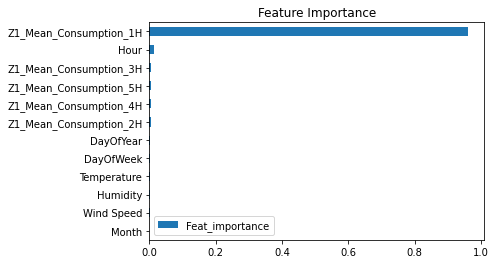

In [35]:
# n_estimators = 1500
# model_xgboost, scores = model.train_xgboost(train_features_1, target1,
#                                                test_features_1, target1_test, 
#                                                n_estimators=n_estimators,
#                                                b_feat_importance=True,
#                                                b_verbose=False)

n_estimators = 1500
model_xgboost, scores = model.train_xgboost(X_train, y_train,
                                               X_test, y_test, 
                                               n_estimators=n_estimators,
                                               b_feat_importance=True,
                                               b_verbose=False)

Au regard de l'importance des variables, nous sélectionnons les variables : Z1_Mean_Consumption_1H et Hour

#### Validation croisée du modèle

In [36]:
# define model evaluation method
# train_best_features_1 = train_features_1['Z1_Mean_Consumption_1H']
n_splits = 2
n_repeats = 2
cross_val_res = model.apply_cross_validation(model_xgboost, X_train, y_train,
                                                n_splits=n_splits, n_repeats=n_repeats)

#### Sauvegarde du meilleur modèle à l'issue de la validation croisée

In [37]:
# Selection du meilleur modèle
test_mae_scores = np.abs(cross_val_res['test_neg_mean_absolute_error']).round(3)
idx_best_model = np.argmin(test_mae_scores)
d_results = dict()
d_results["all_models"] = cross_val_res['estimator']
d_results["best_model"] = cross_val_res['estimator'][idx_best_model]
d_results["dataset"] = d_train_test
d_results["scaler"] = scaler
d_results["cross_val_params"] = {"n_splits":n_splits, "n_repeats":n_repeats}
d_results["cross_val_r2_score"] = {"train":cross_val_res['train_r2'], "test":cross_val_res['test_r2']}
d_results["cross_val_MAE"] = {"train":np.abs(cross_val_res['train_neg_mean_absolute_error']).round(3),
                              "test":np.abs(cross_val_res['test_neg_mean_absolute_error']).round(3)}
 
# Récupérer la date et l'heure pour la création du fichier du modèle
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = os.path.join("models", "XGBoost", target_cols[0], current_datetime)
results_file = os.path.join(results_dir, "xgboost_{}.pkl".format(str(current_datetime)))

# Création du répertoire de sauvegarde des résultats s'il n'existe pas déjà
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

with open(results_file, 'wb') as fp:
    pickle.dump(d_results, fp)

#### Affichage de la prédiction
L'affichage est fait avec le meilleur modèle obtenu après la validation croisée

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=48, ...)


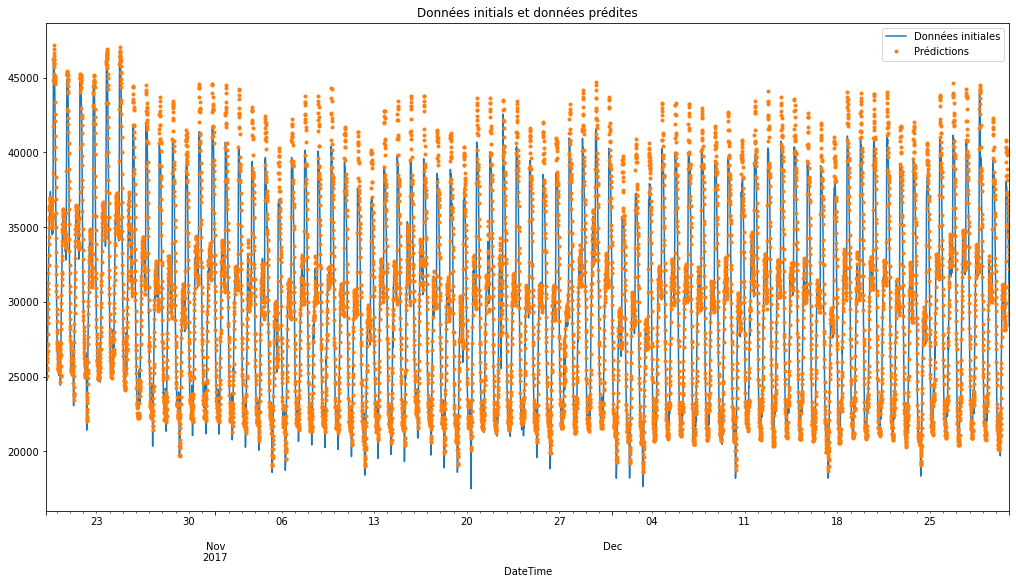

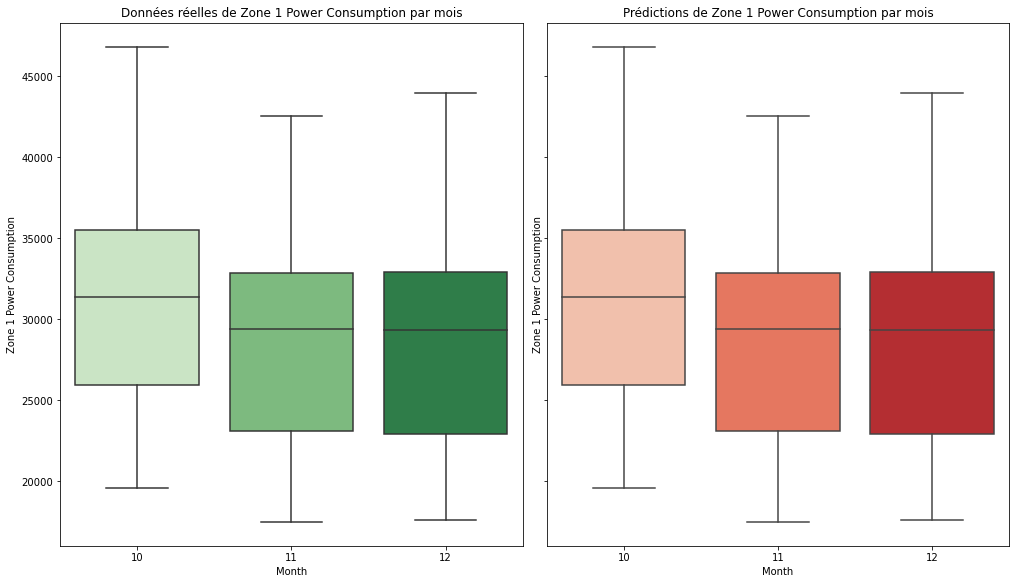

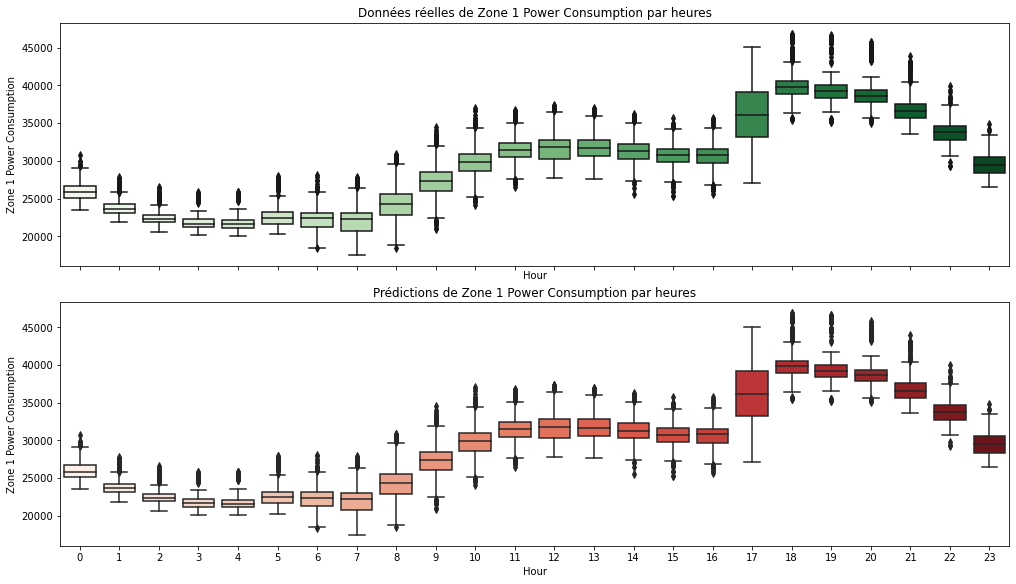

In [38]:
from src.prediction import display_prediction
pred_col_name = "prediction"

# # Sélectionner le meilleur modèle
best_model_xgboost = d_results["best_model"]
print(best_model_xgboost)

# # Calculer les prédictions
df_test = pd.DataFrame(y_test)
df_test[pred_col_name[0]] = best_model_xgboost.predict(X_test)


# Sauvegarde des résultats
df_test.to_pickle(os.path.join(results_dir, "xgboost_predictions_{}_{}.pkl".format(target_cols[0], str(current_datetime))))

pred_col_name="p"
display_prediction(df_test, target_col_name=target_cols[0],
                   pred_col_name=pred_col_name, figsize=(14, 8))

### Model LSTM

In [ ]:
# def create_model():
#     tf.random.set_seed(51)
  
#     model = model.create_uncompiled_model()
  
#     model.compile(loss=tf.keras.losses.Huber(), 
#                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#                   metrics=["mae"])  
#     return model
  
# model = create_model()

# # we train for 20 epochs with and assign the callback
# history = model.fit(dataset, epochs=20, callbacks=[early_stopping])

## Modèle et Prédictions Zone 2

### Modèle XGBoost

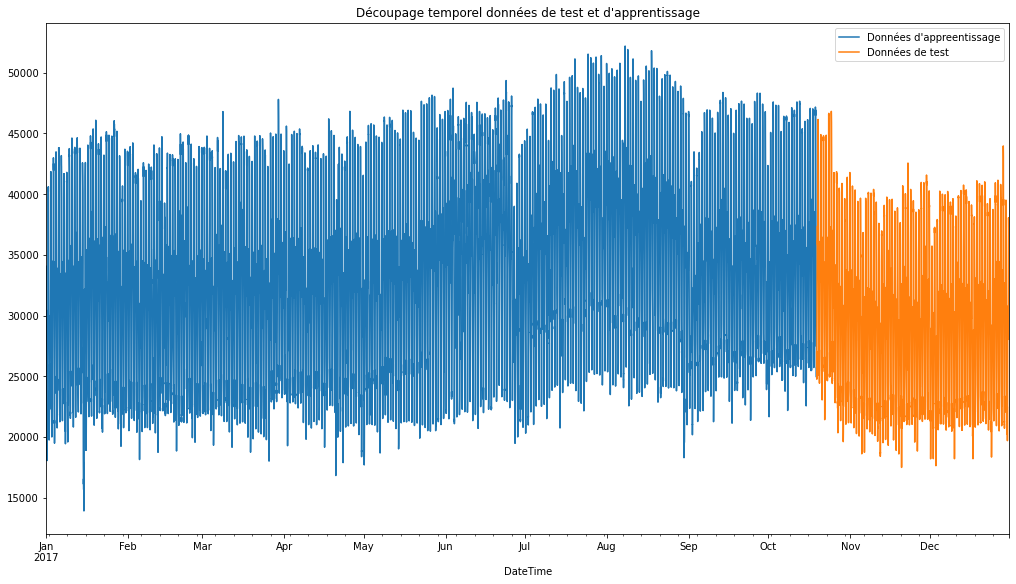

In [23]:
zone_str = "Z2"
target_cols = ["Zone 2 Power Consumption"]
d_train_test, scaler = model.build_train_test_datasets(df_data=df_energy,
                              input_cols=['Temperature', 'Humidity',
                                          'Wind Speed', 'DayOfYear', 'Hour',
                                          'DayOfWeek', 'Month',
                                          '{}_Mean_Consumption_1H'.format(zone_str),
                                          '{}_Mean_Consumption_2H'.format(zone_str),
                                          '{}_Mean_Consumption_3H'.format(zone_str),
                                          '{}_Mean_Consumption_4H'.format(zone_str),
                                          '{}_Mean_Consumption_5H'.format(zone_str)], 
                              target_cols=target_cols,
                              train_ratio=0.8, scaler_str=None)

X_train = d_train_test["NonScaled"]["train"]["Inputs"]
y_train = d_train_test["NonScaled"]["train"]["Target"]
X_test = d_train_test["NonScaled"]["test"]["Inputs"]
y_test = d_train_test["NonScaled"]["test"]["Target"]

Performance du modèle
	 --> Score R2 (Le modèle parfait a un score de 1)
	 	 --> Ensemble d'apprentissage : 0.999
	 	 --> Ensemble de test : 0.978


	 --> MAE (Erreur moyenne absolue) en KW
	 	 --> Ensemble d'apprentissage : 164.261
	 	 --> Ensemble de test : 594.549


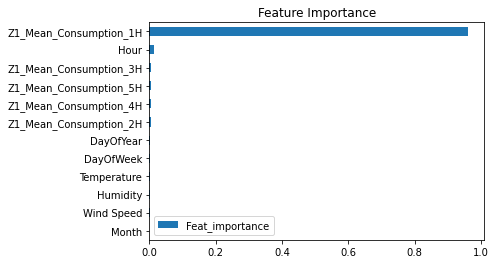

In [35]:
n_estimators = 1500
model_xgboost, scores = model.train_xgboost(X_train, y_train,
                                               X_test, y_test, 
                                               n_estimators=n_estimators,
                                               b_feat_importance=True,
                                               b_verbose=False)

Au regard de l'importance des variables, nous sélectionnons les variables : Z1_Mean_Consumption_1H et Hour

#### Validation croisée du modèle

In [36]:
# define model evaluation method
# train_best_features_1 = train_features_1['Z1_Mean_Consumption_1H']
n_splits = 2
n_repeats = 2
cross_val_res = model.apply_cross_validation(model_xgboost, X_train, y_train,
                                                n_splits=n_splits, n_repeats=n_repeats)

#### Sauvegarde du meilleur modèle à l'issue de la validation croisée

In [37]:
# Selection du meilleur modèle
test_mae_scores = np.abs(cross_val_res['test_neg_mean_absolute_error']).round(3)
idx_best_model = np.argmin(test_mae_scores)
d_results = dict()
d_results["all_models"] = cross_val_res['estimator']
d_results["best_model"] = cross_val_res['estimator'][idx_best_model]
d_results["dataset"] = d_train_test
d_results["scaler"] = scaler
d_results["cross_val_params"] = {"n_splits":n_splits, "n_repeats":n_repeats}
d_results["cross_val_r2_score"] = {"train":cross_val_res['train_r2'], "test":cross_val_res['test_r2']}
d_results["cross_val_MAE"] = {"train":np.abs(cross_val_res['train_neg_mean_absolute_error']).round(3),
                              "test":np.abs(cross_val_res['test_neg_mean_absolute_error']).round(3)}
 
# Récupérer la date et l'heure pour la création du fichier du modèle
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = os.path.join("models", "XGBoost", target_cols[0], current_datetime)
results_file = os.path.join(results_dir, "xgboost_{}.pkl".format(str(current_datetime)))

# Création du répertoire de sauvegarde des résultats s'il n'existe pas déjà
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

with open(results_file, 'wb') as fp:
    pickle.dump(d_results, fp)

#### Affichage de la prédiction
L'affichage est fait avec le meilleur modèle obtenu après la validation croisée

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=48, ...)


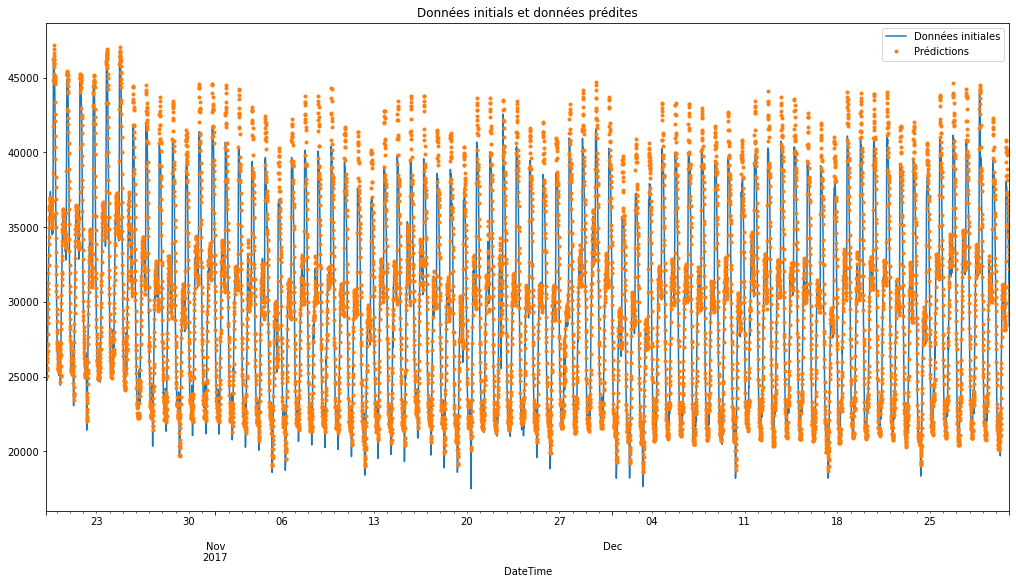

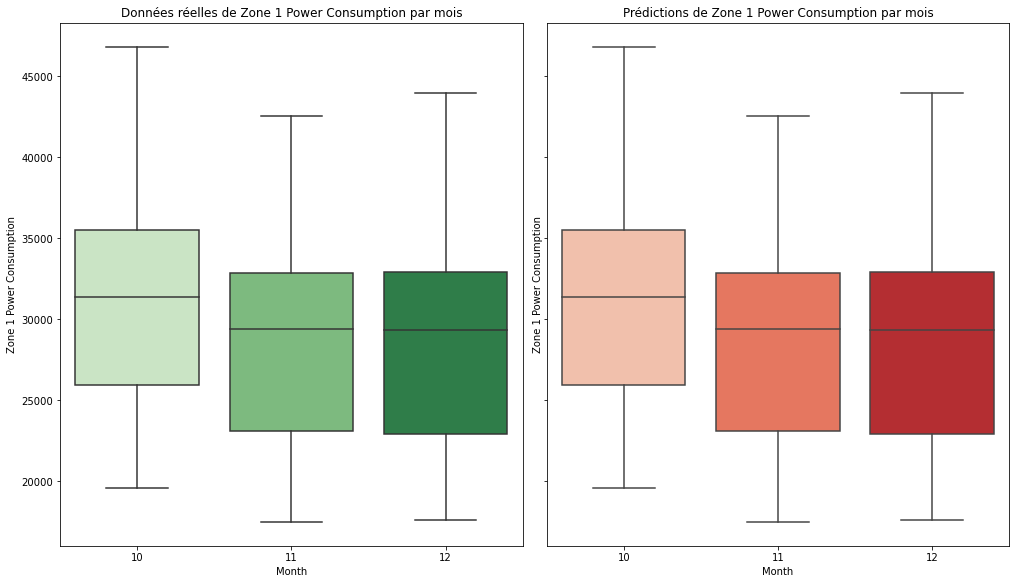

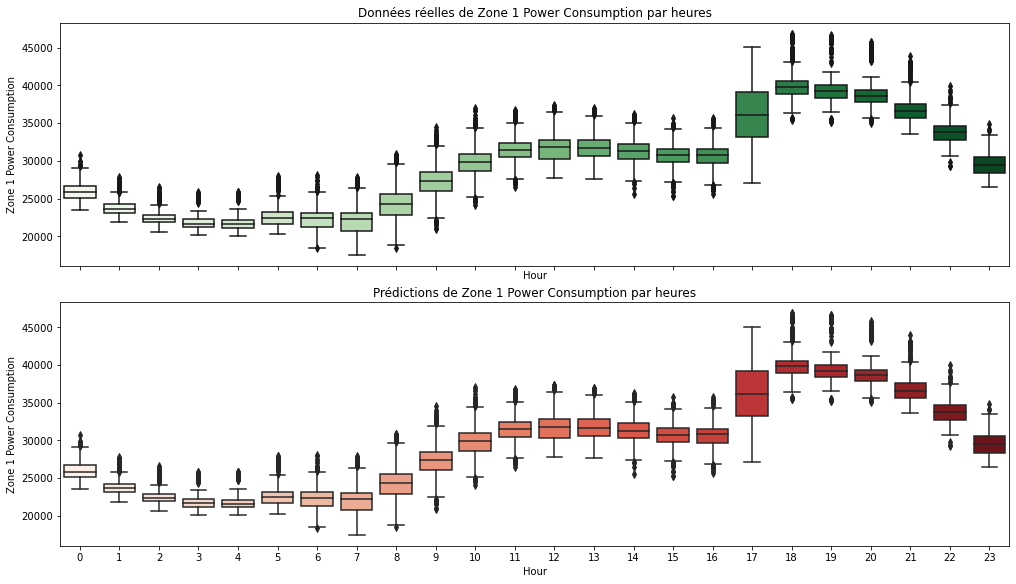

In [38]:
from src.prediction import display_prediction
pred_col_name = "prediction"

# # Sélectionner le meilleur modèle
best_model_xgboost = d_results["best_model"]
print(best_model_xgboost)

# # Calculer les prédictions
df_test = pd.DataFrame(y_test)
df_test[pred_col_name[0]] = best_model_xgboost.predict(X_test)


# Sauvegarde des résultats
df_test.to_pickle(os.path.join(results_dir, "xgboost_predictions_{}_{}.pkl".format(target_cols[0], str(current_datetime))))

pred_col_name="p"
display_prediction(df_test, target_col_name=target_cols[0],
                   pred_col_name=pred_col_name, figsize=(14, 8))

## Modèle et Prédictions Zone 3

### Modèle XGBoost

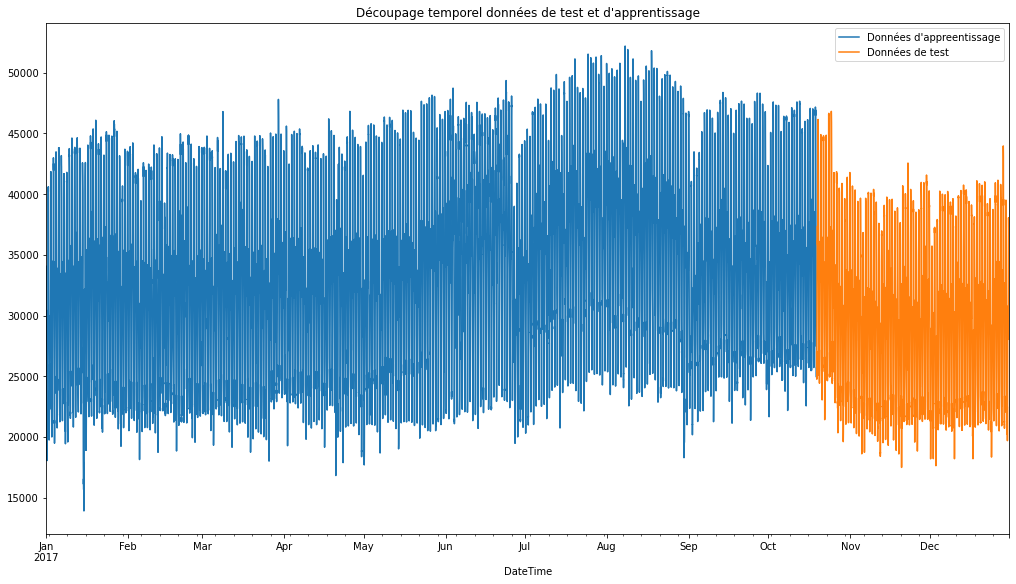

In [23]:
zone_str = "Z2"
target_cols = ["Zone 3 Power Consumption"]
d_train_test, scaler = model.build_train_test_datasets(df_data=df_energy,
                              input_cols=['Temperature', 'Humidity',
                                          'Wind Speed', 'DayOfYear', 'Hour',
                                          'DayOfWeek', 'Month',
                                          '{}_Mean_Consumption_1H'.format(zone_str),
                                          '{}_Mean_Consumption_2H'.format(zone_str),
                                          '{}_Mean_Consumption_3H'.format(zone_str),
                                          '{}_Mean_Consumption_4H'.format(zone_str),
                                          '{}_Mean_Consumption_5H'.format(zone_str)], 
                              target_cols=target_cols,
                              train_ratio=0.8, scaler_str=None)

X_train = d_train_test["NonScaled"]["train"]["Inputs"]
y_train = d_train_test["NonScaled"]["train"]["Target"]
X_test = d_train_test["NonScaled"]["test"]["Inputs"]
y_test = d_train_test["NonScaled"]["test"]["Target"]

Performance du modèle
	 --> Score R2 (Le modèle parfait a un score de 1)
	 	 --> Ensemble d'apprentissage : 0.999
	 	 --> Ensemble de test : 0.978


	 --> MAE (Erreur moyenne absolue) en KW
	 	 --> Ensemble d'apprentissage : 164.261
	 	 --> Ensemble de test : 594.549


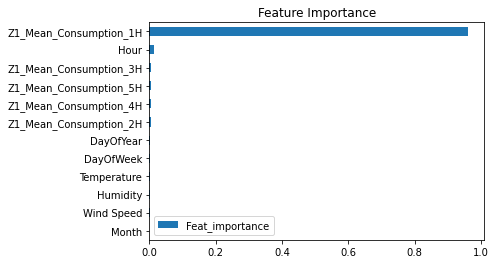

In [35]:
n_estimators = 1500
model_xgboost, scores = model.train_xgboost(X_train, y_train,
                                               X_test, y_test, 
                                               n_estimators=n_estimators,
                                               b_feat_importance=True,
                                               b_verbose=False)

Au regard de l'importance des variables, nous sélectionnons les variables : Z1_Mean_Consumption_1H et Hour

#### Validation croisée du modèle

In [36]:
# define model evaluation method
# train_best_features_1 = train_features_1['Z1_Mean_Consumption_1H']
n_splits = 2
n_repeats = 2
cross_val_res = model.apply_cross_validation(model_xgboost, X_train, y_train,
                                                n_splits=n_splits, n_repeats=n_repeats)

#### Sauvegarde du meilleur modèle à l'issue de la validation croisée

In [37]:
# Selection du meilleur modèle
test_mae_scores = np.abs(cross_val_res['test_neg_mean_absolute_error']).round(3)
idx_best_model = np.argmin(test_mae_scores)
d_results = dict()
d_results["all_models"] = cross_val_res['estimator']
d_results["best_model"] = cross_val_res['estimator'][idx_best_model]
d_results["dataset"] = d_train_test
d_results["scaler"] = scaler
d_results["cross_val_params"] = {"n_splits":n_splits, "n_repeats":n_repeats}
d_results["cross_val_r2_score"] = {"train":cross_val_res['train_r2'], "test":cross_val_res['test_r2']}
d_results["cross_val_MAE"] = {"train":np.abs(cross_val_res['train_neg_mean_absolute_error']).round(3),
                              "test":np.abs(cross_val_res['test_neg_mean_absolute_error']).round(3)}
 
# Récupérer la date et l'heure pour la création du fichier du modèle
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = os.path.join("models", "XGBoost", target_cols[0], current_datetime)
results_file = os.path.join(results_dir, "xgboost_{}.pkl".format(str(current_datetime)))

# Création du répertoire de sauvegarde des résultats s'il n'existe pas déjà
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

with open(results_file, 'wb') as fp:
    pickle.dump(d_results, fp)

#### Affichage de la prédiction
L'affichage est fait avec le meilleur modèle obtenu après la validation croisée

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=48, ...)


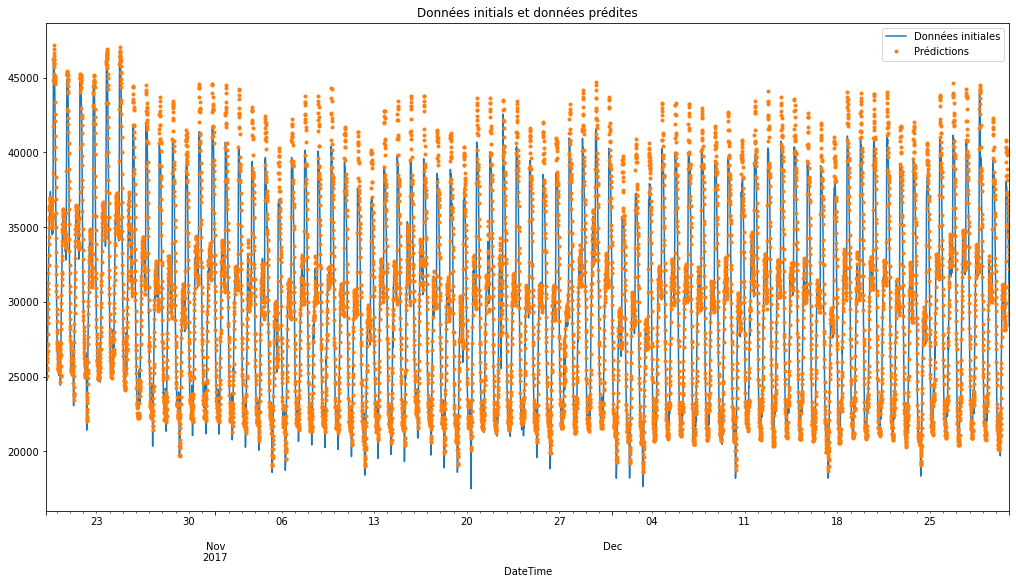

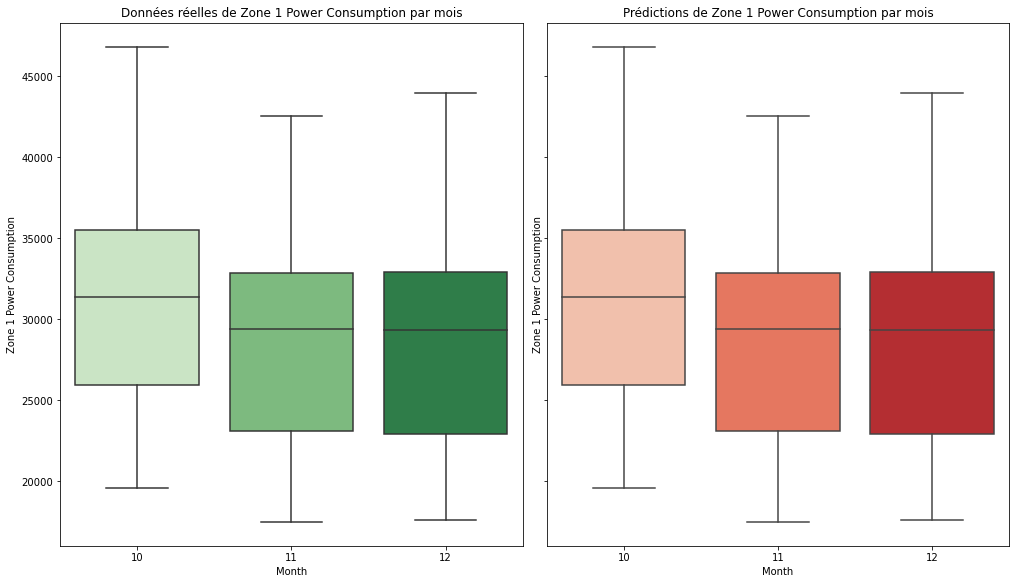

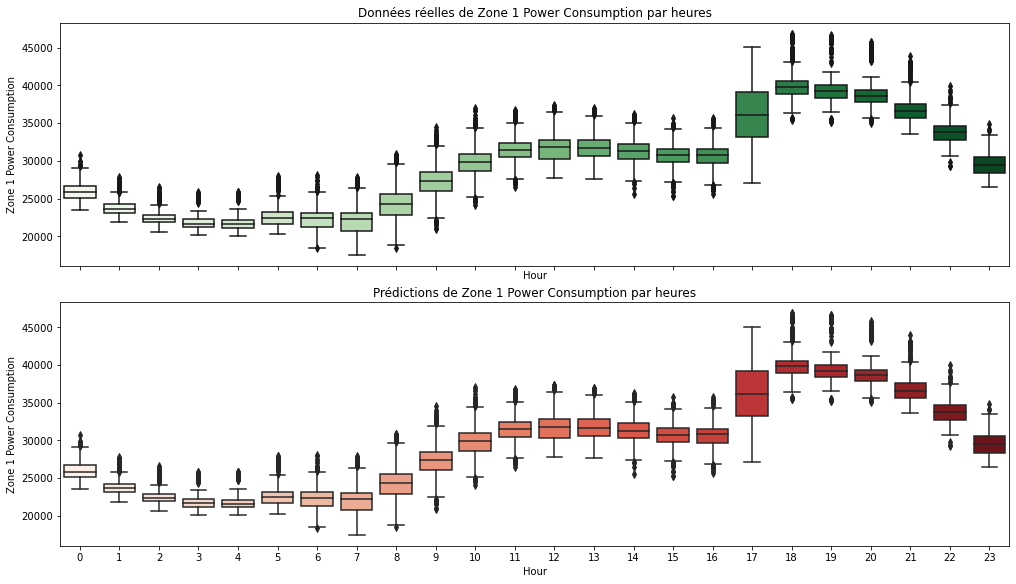

In [38]:
from src.prediction import display_prediction
pred_col_name = "prediction"

# # Sélectionner le meilleur modèle
best_model_xgboost = d_results["best_model"]
print(best_model_xgboost)

# # Calculer les prédictions
df_test = pd.DataFrame(y_test)
df_test[pred_col_name[0]] = best_model_xgboost.predict(X_test)


# Sauvegarde des résultats
df_test.to_pickle(os.path.join(results_dir, "xgboost_predictions_{}_{}.pkl".format(target_cols[0], str(current_datetime))))

pred_col_name="p"
display_prediction(df_test, target_col_name=target_cols[0],
                   pred_col_name=pred_col_name, figsize=(14, 8))